In [2]:
import pandas as pd
import geopandas as gpd
from geopandas.tools import geocode
import matplotlib.pyplot as plt
import mapclassify
from shapely.ops import nearest_points
from shapely.geometry import LineString

#pd.options.display.max_colwidth= 200
#pd.set_option('display.max_rows', 20)

# Preparing Data

## Agencies Data

In [3]:
sp_shp = gpd.read_file('C:/Users/Ricardo/Documents/R-Projetos/Exploratory-Data-Analysis-Bancarization/data/raw/municipio_sp.shp')

In [4]:
gdf_agencias_sp = pd.read_csv('C:/Users/Ricardo/Documents/R-Projetos/Exploratory-Data-Analysis-Bancarization/data/processed/agencias_latlong.csv', sep=';')

In [5]:
# Set crs to use degrees in the first moment
# https://gis.stackexchange.com/questions/345071/matching-x-and-y-axis-coordinates-of-two-geopandas-geometries-to-overlay-them
gdf_agencias_sp_points = gpd.GeoDataFrame(gdf_agencias_sp, geometry=gpd.points_from_xy(gdf_agencias_sp['lon'], gdf_agencias_sp['lat']), crs=4326)

In [6]:
# Then, set the crs of points to the crs of shapefile map which is in meters
gdf_agencias_sp_points = gdf_agencias_sp_points.to_crs(sp_shp.crs)

In [7]:
# Spatial join to get only the points inside polygon
gdf_agencias_sp_points_join = gpd.sjoin(gdf_agencias_sp_points, sp_shp, predicate='within')

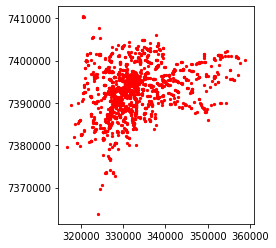

In [8]:
gdf_agencias_sp_points_join.plot(marker='o', color='red', markersize=5);

# Calculating New Features

## Centroid

In [10]:
sp_shp["centroid"] = sp_shp.centroid

In [16]:
#sp_shp['menor_distancia'] = sp_shp.centroid.distance(gdf_agencias_sp_points_join)

C:\Users\Ricardo\Anaconda3\lib\site-packages\geopandas\base.py:31: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")


In [12]:
sp_shp.centroid

0     POINT (353834.211 7392983.063)
1     POINT (322676.391 7380084.928)
2     POINT (348377.652 7395944.389)
3     POINT (321658.159 7398867.737)
4     POINT (339562.029 7390046.264)
                   ...              
91    POINT (338955.010 7398846.264)
92    POINT (333123.055 7390644.123)
93    POINT (345103.311 7395997.013)
94    POINT (331310.534 7396682.496)
95    POINT (332534.414 7395260.261)
Length: 96, dtype: geometry

## Nearest Agency

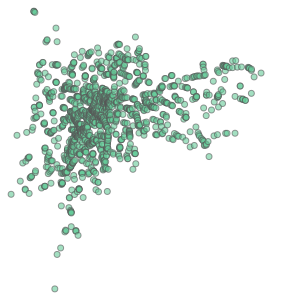

In [13]:
# Unary_union is used to create a multipoint structure
# https://autogis-site.readthedocs.io/en/latest/notebooks/L3/04_nearest-neighbour.html
gdf_agencias_sp_points_join.unary_union

In [14]:
def get_nearest_values(row, other_gdf, point_column='geometry', value_column="geometry"):
    """Find the nearest point and return the corresponding value from specified value column."""
    
    # Create an union of the other GeoDataFrame's geometries:
    other_points = other_gdf["geometry"].unary_union
    
    # Find the nearest points
    nearest_geoms = nearest_points(row[point_column], other_points)
    
    # Get corresponding values from the other df
    nearest_data = other_gdf.loc[other_gdf["geometry"] == nearest_geoms[1]]
    
    nearest_value = nearest_data[value_column].values[0]
    
    return nearest_value

In [15]:
sp_shp["agencia_mais_proxima"] = sp_shp.apply(get_nearest_values, other_gdf=gdf_agencias_sp_points_join, point_column="centroid", axis=1)

In [17]:
sp_shp["agencia_mais_proxima"]

,CLASSID,FEATID,REVISIONNU,NOME_DIST,SIGLA_DIST,COD_DIST,COD_SUB,DATA_CRIAC,USUARIO_ID,geometry,centroid,agencia_mais_proxima
0,4.0,8583485.0,1.0,JOSE BONIFACIO,JBO,47,27,2007-03-19,0.0,"POLYGON ((352436.869 7394174.148, 352450.740 7394171.541, 352468.533 7394165.397, 352468.790 7394165.296, 352469.049 7394165.200, 352469.310 7394165.108, 352469.572 7394165.020, 352469.836 7394164...",POINT (353834.211 7392983.063),POINT (352302.4364832666 7394955.645497645)
1,4.0,8583484.0,1.0,JD SAO LUIS,JDS,46,18,2007-03-19,0.0,"POLYGON ((320696.639 7383620.282, 320699.486 7383649.788, 320702.058 7383673.108, 320710.167 7383697.811, 320718.899 7383717.115, 320735.910 7383745.375, 320753.514 7383769.485, 320771.957 7383787...",POINT (322676.391 7380084.928),POINT (322363.2000065215 7381017.757298688)
2,4.0,8583445.0,1.0,ARTUR ALVIM,AAL,5,21,2007-03-19,0.0,"POLYGON ((349461.276 7397764.525, 349461.935 7397761.333, 349461.965 7397759.985, 349465.688 7397740.335, 349468.519 7397725.394, 349472.124 7397705.722, 349474.622 7397692.094, 349478.228 7397672...",POINT (348377.652 7395944.389),POINT (347951.8908333202 7396067.959863355)
3,4.0,8583479.0,1.0,JAGUARA,JAG,40,08,2007-03-19,0.0,"POLYGON ((320731.080 7400614.592, 320732.386 7400615.950, 320733.408 7400617.013, 320733.627 7400617.241, 320734.128 7400617.762, 320738.189 7400621.986, 320741.677 7400625.614, 320743.231 7400627...",POINT (321658.159 7398867.737),POINT (321810.2118726268 7398886.744106924)
4,4.0,8583437.0,1.0,VILA PRUDENTE,VPR,93,29,2007-03-19,0.0,"POLYGON ((338651.039 7392203.484, 338654.034 7392200.262, 338659.593 7392194.280, 338661.508 7392193.188, 338663.707 7392191.202, 338668.599 7392186.674, 338677.344 7392178.673, 338695.441 7392162...",POINT (339562.029 7390046.264),POINT (339147.9798142896 7390336.702797015)
...,...,...,...,...,...,...,...,...,...,...,...,...
91,4.0,8583433.0,1.0,VILA MARIA,VMR,89,07,2007-03-19,0.0,"POLYGON ((338228.823 7397145.610, 338216.895 7397141.953, 338187.099 7397133.249, 338088.140 7397102.216, 338055.523 7397092.625, 337942.320 7397057.139, 337851.621 7397034.794, 337850.795 7397034...",POINT (338955.010 7398846.264),POINT (338331.0322886222 7398781.362539189)
92,4.0,8583434.0,1.0,VILA MARIANA,VMN,90,12,2007-03-19,0.0,"POLYGON ((331606.384 7389277.797, 331607.340 7389290.780, 331608.530 7389307.630, 331609.690 7389325.850, 331610.990 7389345.300, 331611.420 7389352.420, 331612.780 7389371.850, 331613.950 7389392...",POINT (333123.055 7390644.123),POINT (333144.3713397966 7390496.377464311)
93,4.0,8583435.0,1.0,VILA MATILDE,VMT,91,21,2007-03-19,0.0,"POLYGON ((341994.993 7396441.620, 341979.394 7396497.257, 342094.680 7396522.530, 342276.860 7396560.820, 342382.452 7396584.862, 342487.300 7396608.480, 342573.236 7396627.878, 342620.991 7396638...",POINT (345103.311 7395997.013),POINT (344819.8109995762 7395537.840644479)
94,4.0,8583412.0,1.0,SANTA CECILIA,SCE,69,09,2007-03-19,0.0,"POLYGON ((330220.609 7396091.962, 330226.819 7396102.563, 330231.141 7396109.941, 330242.092 7396133.608, 330256.923 7396166.239, 330273.199 7396201.862, 330315.251 7396296.367, 330370.898 7396420...",POINT (331310.534 7396682.496),POINT (331295.8973385801 7396524.690199891)


## Creating a GeoDataFrame of the Lines Between Centroid and Nearest Agency

In [19]:
sp_shp['link'] = sp_shp.apply(lambda row: LineString([row['centroid'], row['agencia_mais_proxima']]), axis=1)

In [20]:
link = gpd.GeoDataFrame(sp_shp["link"], geometry=sp_shp["link"], crs=sp_shp.crs)

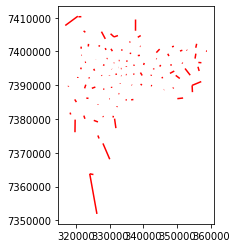

In [21]:
link.plot(marker='o', color='red', markersize=5);

## Plot

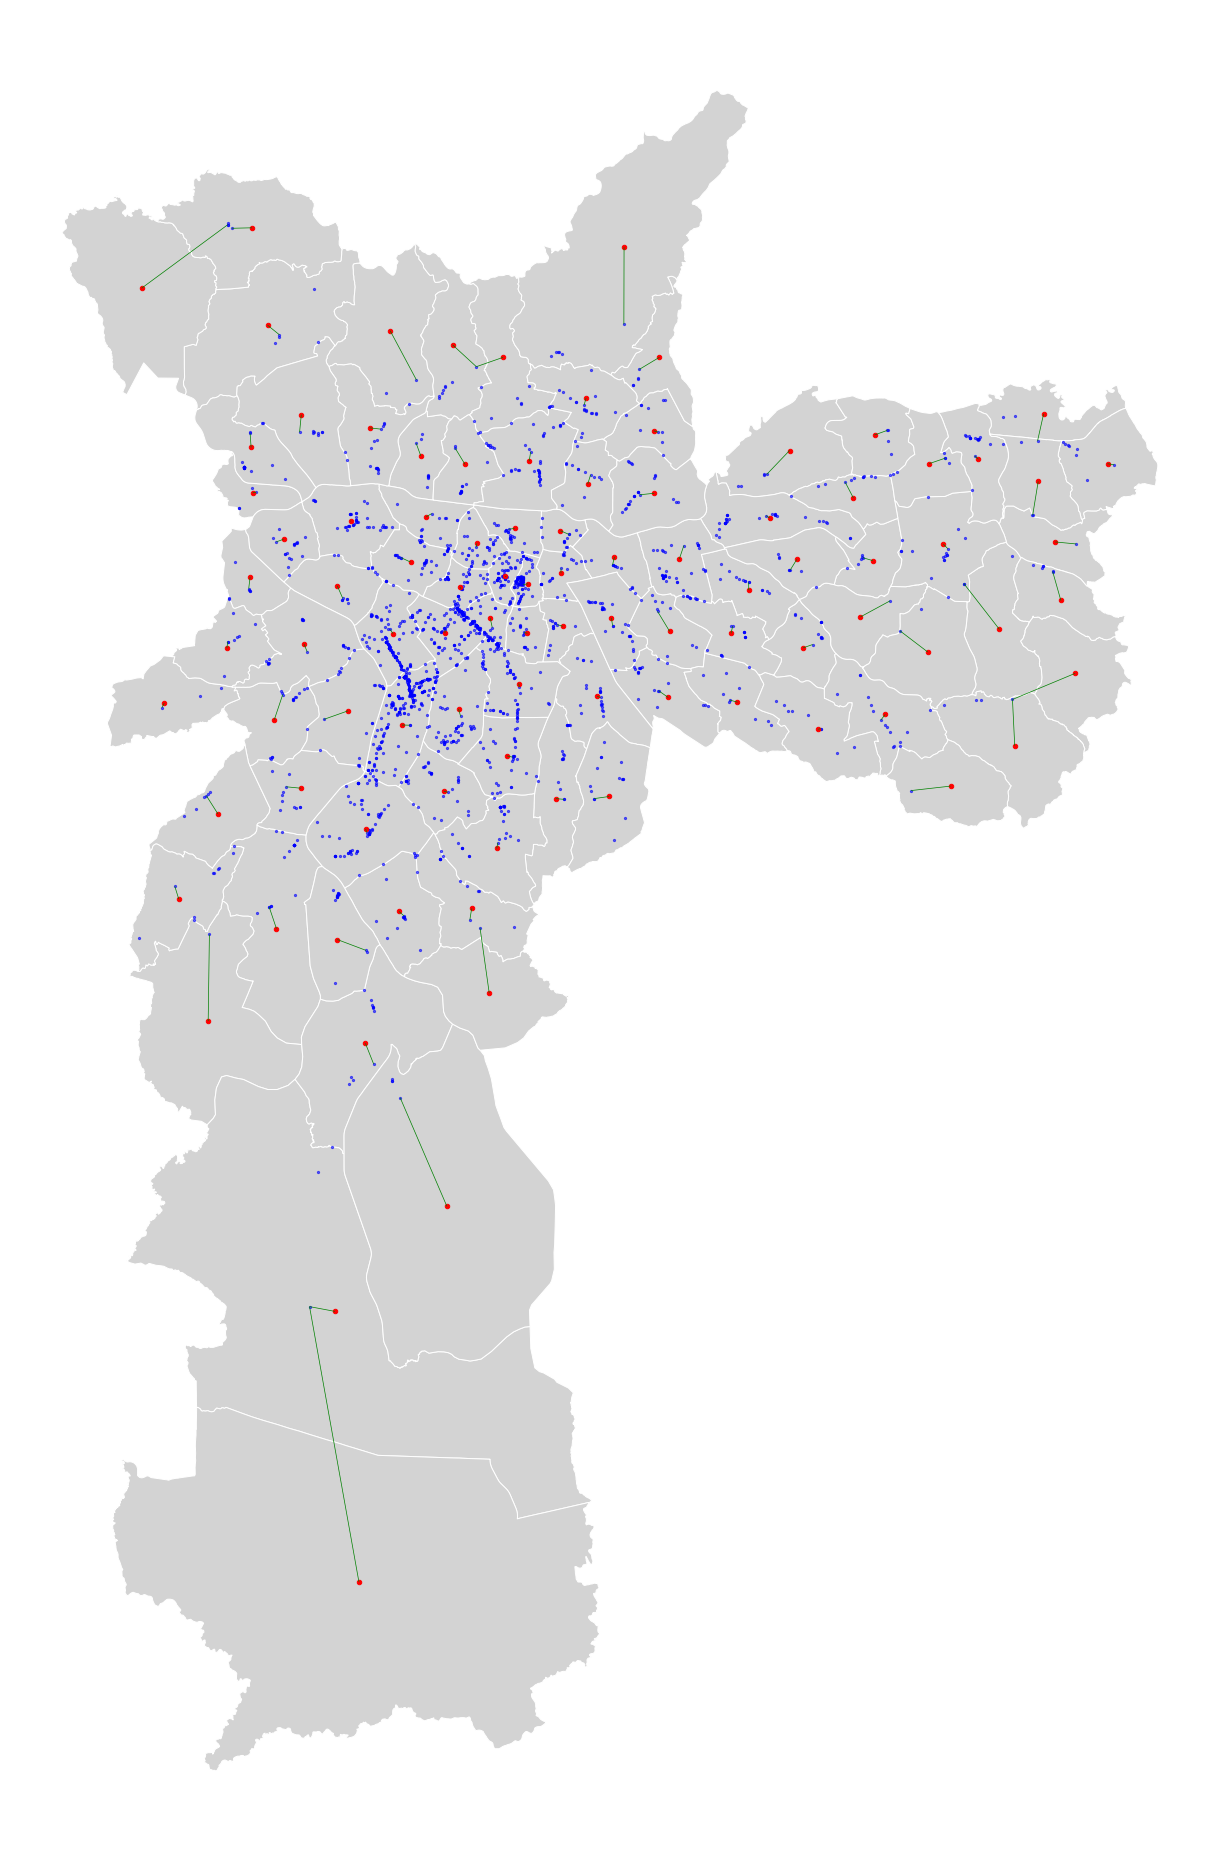

In [34]:
fig, ax = plt.subplots(figsize=(40,34))

# Set bg colors
ax.set(facecolor = "white")
fig.patch.set_facecolor('white')

# Plot polygons
sp_shp.plot(ax=ax, facecolor='lightgrey', edgecolor="white")

# Plot points
gdf_agencias_sp_points_join.plot(ax=ax, color='blue', markersize=5, alpha=0.6)
sp_shp.centroid.plot(ax=ax, color='red', markersize=20)

# Plot lines
link.plot(ax=ax, color='green', lw=0.7)

ax.axis("off")
plt.show()

## Calculating Min, Max, Mean and Std Metrics

In [35]:
sp_shp['menor_distancia'] = sp_shp.centroid.apply(lambda x: gdf_agencias_sp_points_join.distance(x).min())
sp_shp['maior_distancia'] = sp_shp.centroid.apply(lambda x: gdf_agencias_sp_points_join.distance(x).max())
sp_shp['distancia_media'] = sp_shp.centroid.apply(lambda x: gdf_agencias_sp_points_join.distance(x).mean())
sp_shp['distancia_desvio_padrao'] = sp_shp.centroid.apply(lambda x: gdf_agencias_sp_points_join.distance(x).std())

C:\Users\Ricardo\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


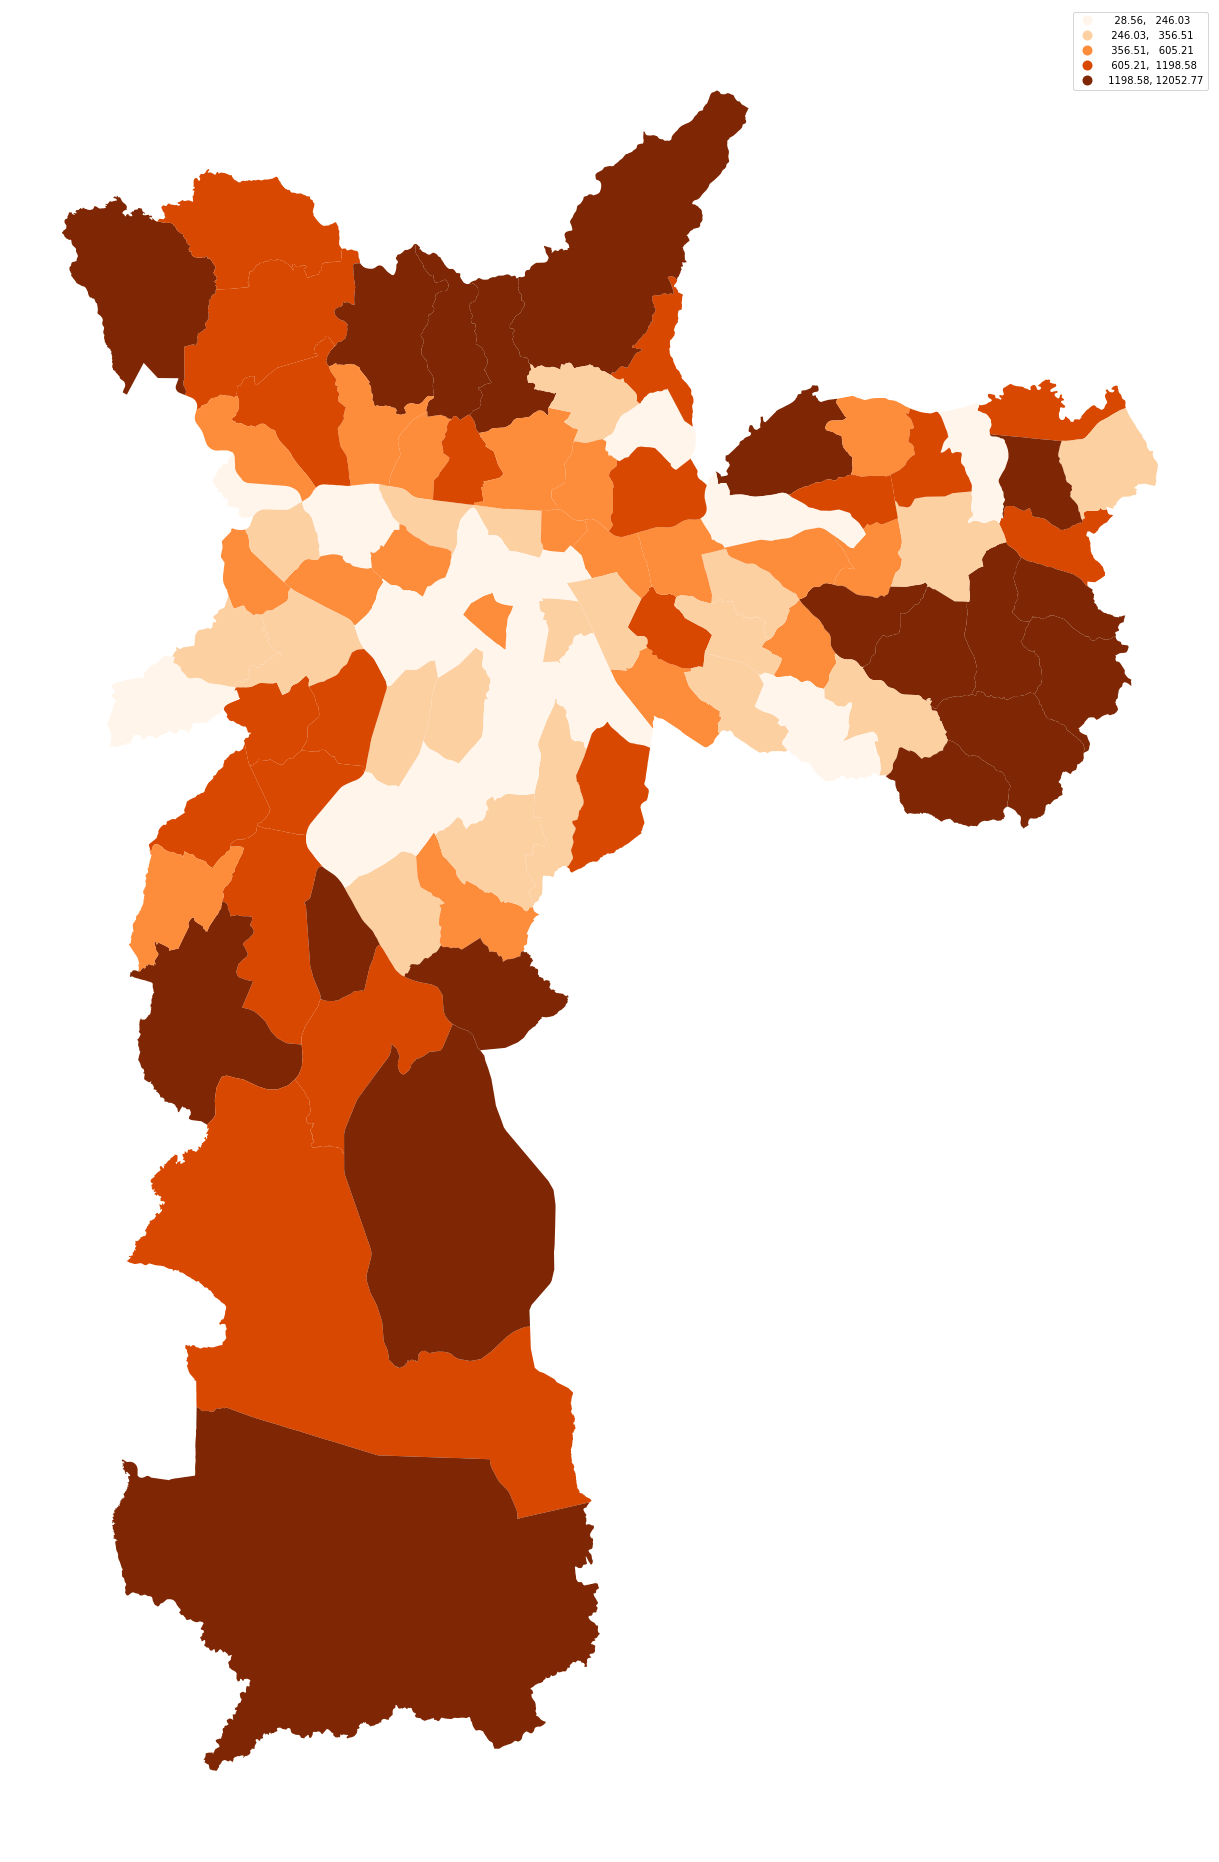

In [36]:
fig, ax = plt.subplots(figsize=(40,34))

# Set bg colors
ax.set(facecolor = "white")
fig.patch.set_facecolor('white')

# Plot
sp_shp.plot(column='menor_distancia', scheme="Quantiles", k= 5, cmap="Oranges", legend=True, ax=ax)

ax.axis("off")
plt.show()

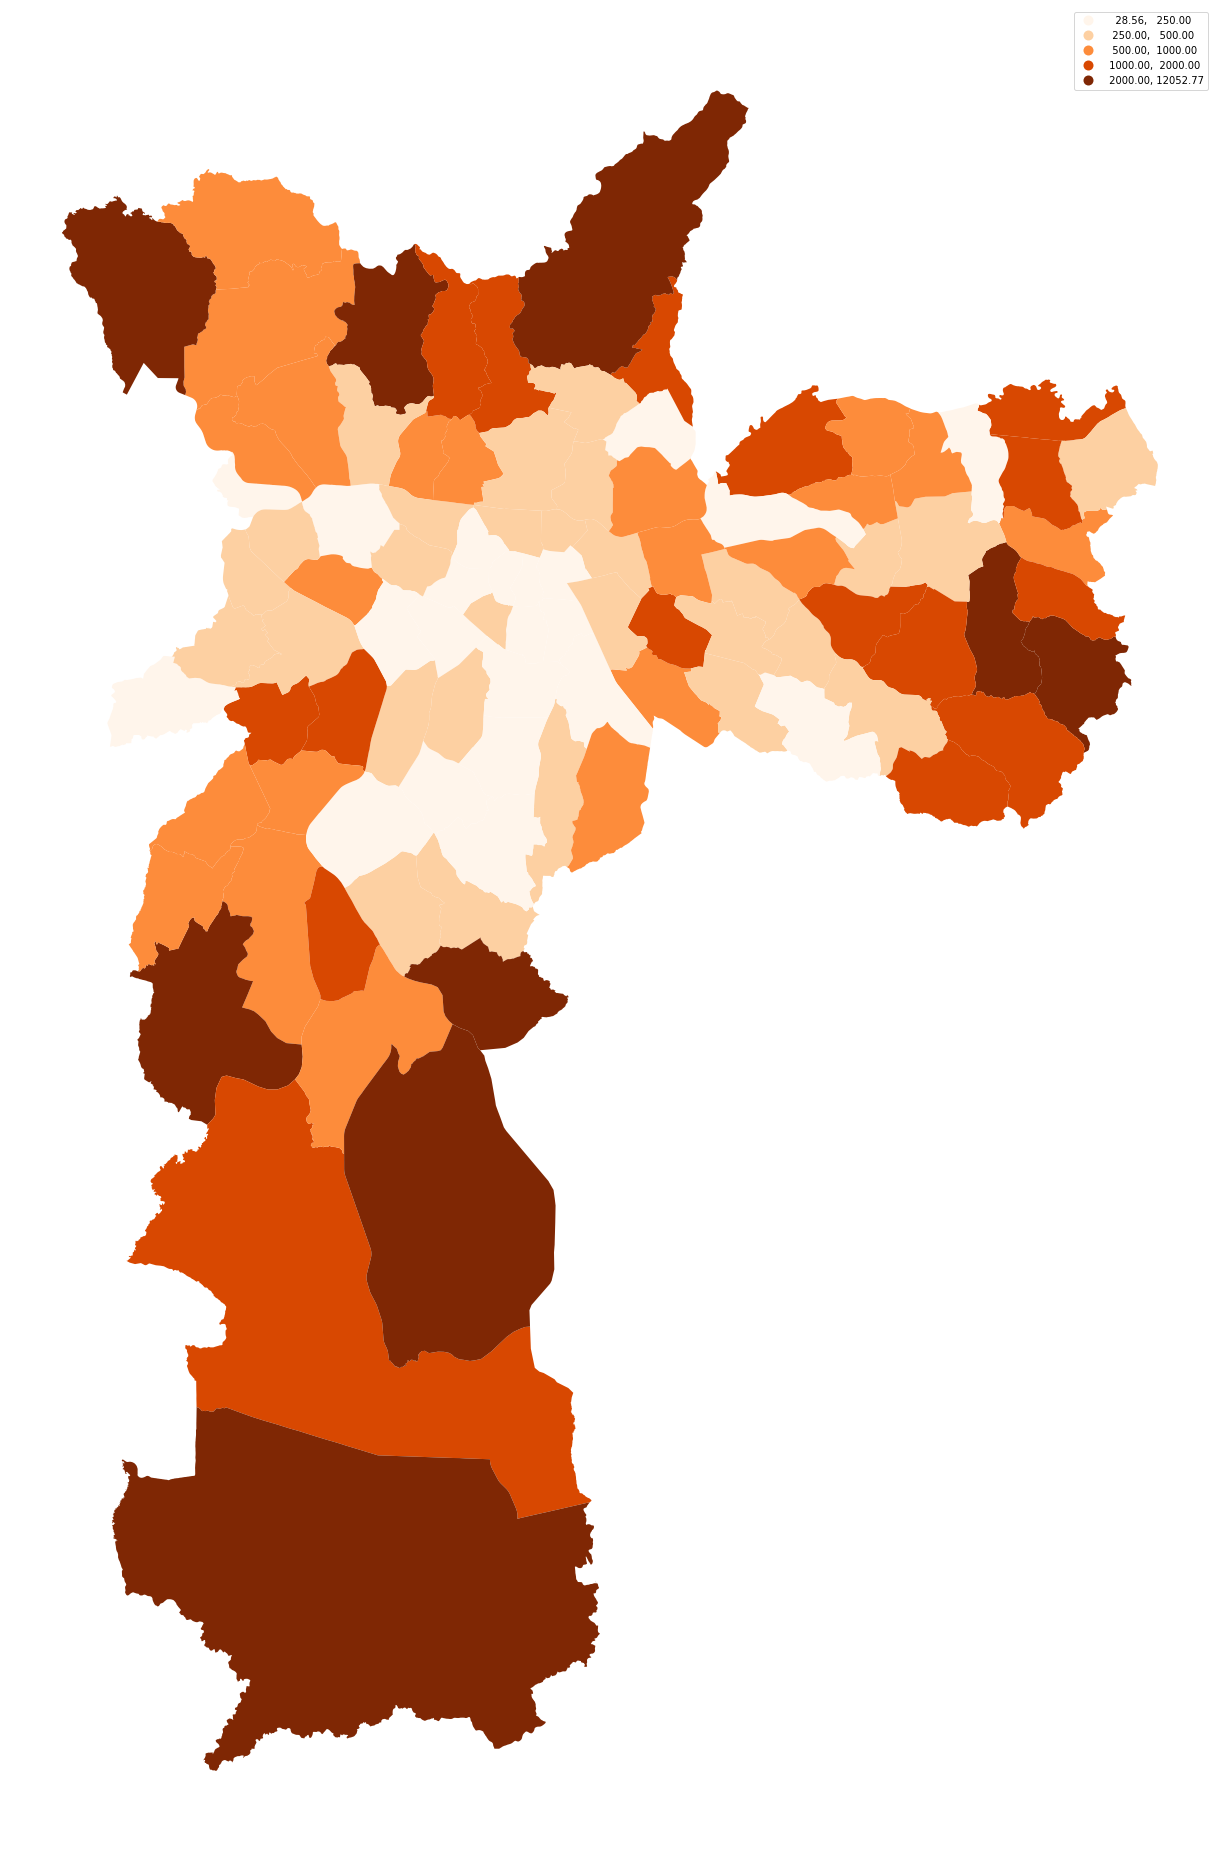

In [29]:
fig, ax = plt.subplots(figsize=(40,34))

# Set bg colors
ax.set(facecolor = "white")
fig.patch.set_facecolor('white')

# Plot
sp_shp.plot(column='menor_distancia', scheme="User_Defined", classification_kwds=dict(bins=[250,500,1000,2000]), cmap="Oranges", legend=True, ax=ax)

ax.axis("off")
plt.show()

C:\Users\Ricardo\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


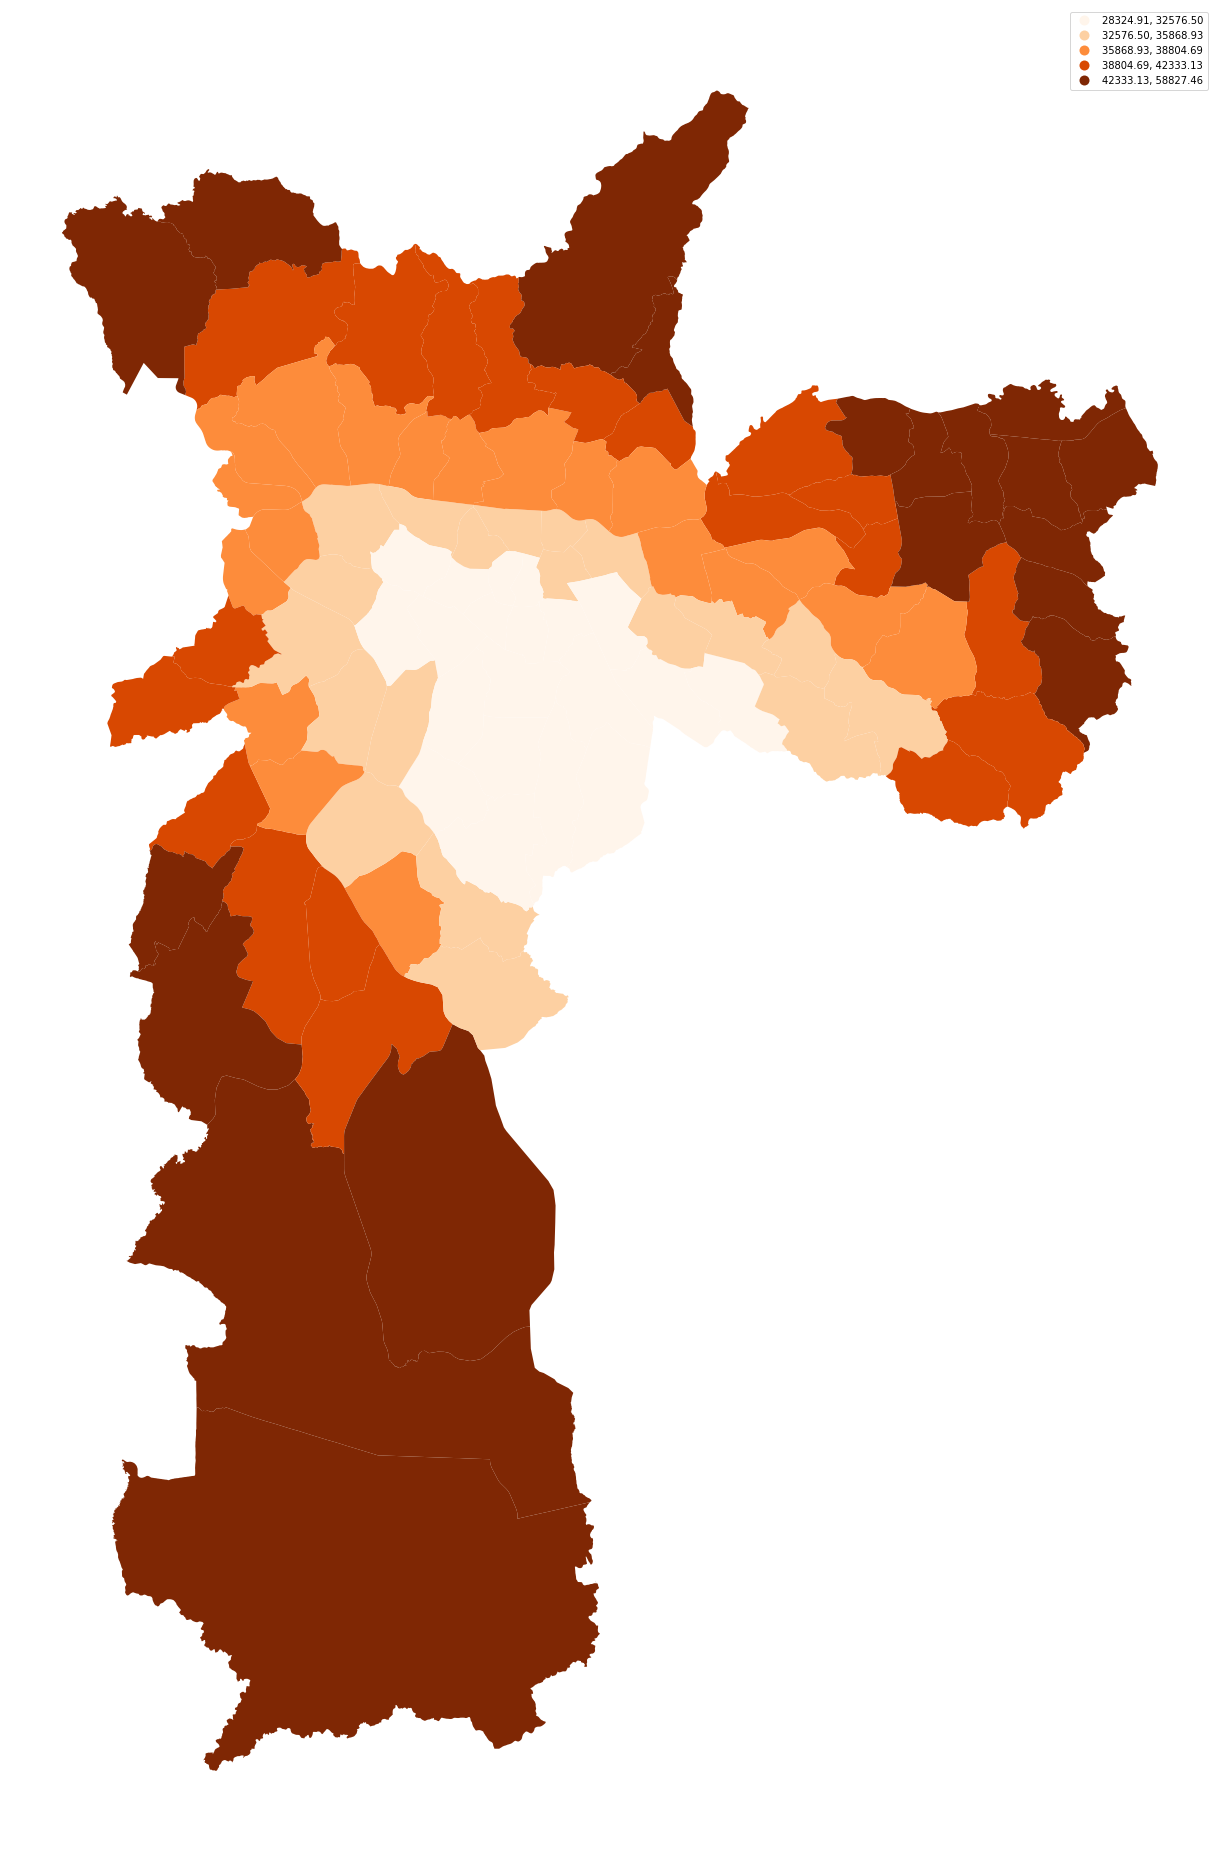

In [44]:
fig, ax = plt.subplots(figsize=(40,34))

# Set bg colors
ax.set(facecolor = "white")
fig.patch.set_facecolor('white')

# Plot
sp_shp.plot(column='maior_distancia', scheme="Quantiles", k= 5, cmap="Oranges", legend=True, ax=ax)

ax.axis("off")
plt.show()

C:\Users\Ricardo\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


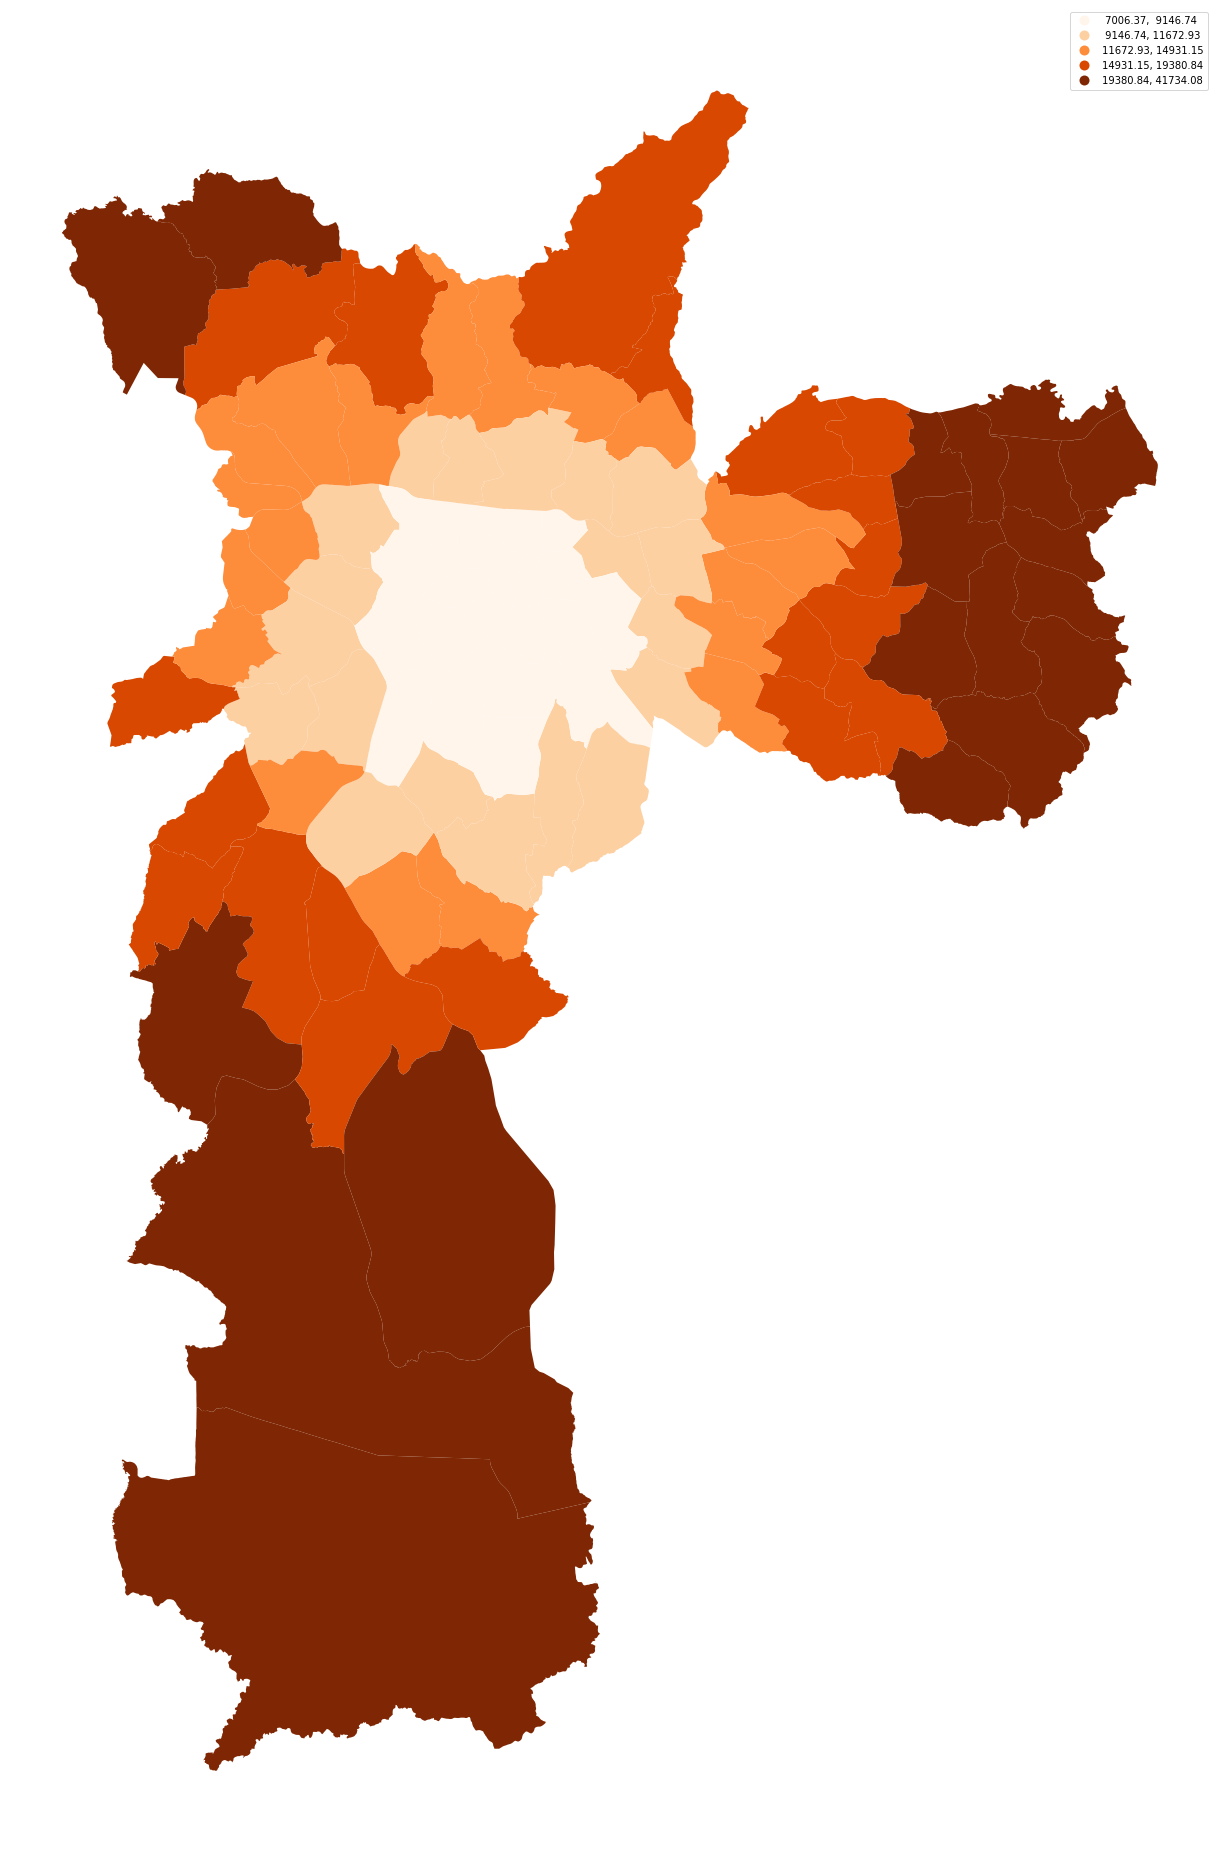

In [45]:
fig, ax = plt.subplots(figsize=(40,34))

# Set bg colors
ax.set(facecolor = "white")
fig.patch.set_facecolor('white')

# Plot
sp_shp.plot(column='distancia_media', scheme="Quantiles", k= 5, cmap="Oranges", legend=True, ax=ax)

ax.axis("off")
plt.show()

C:\Users\Ricardo\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


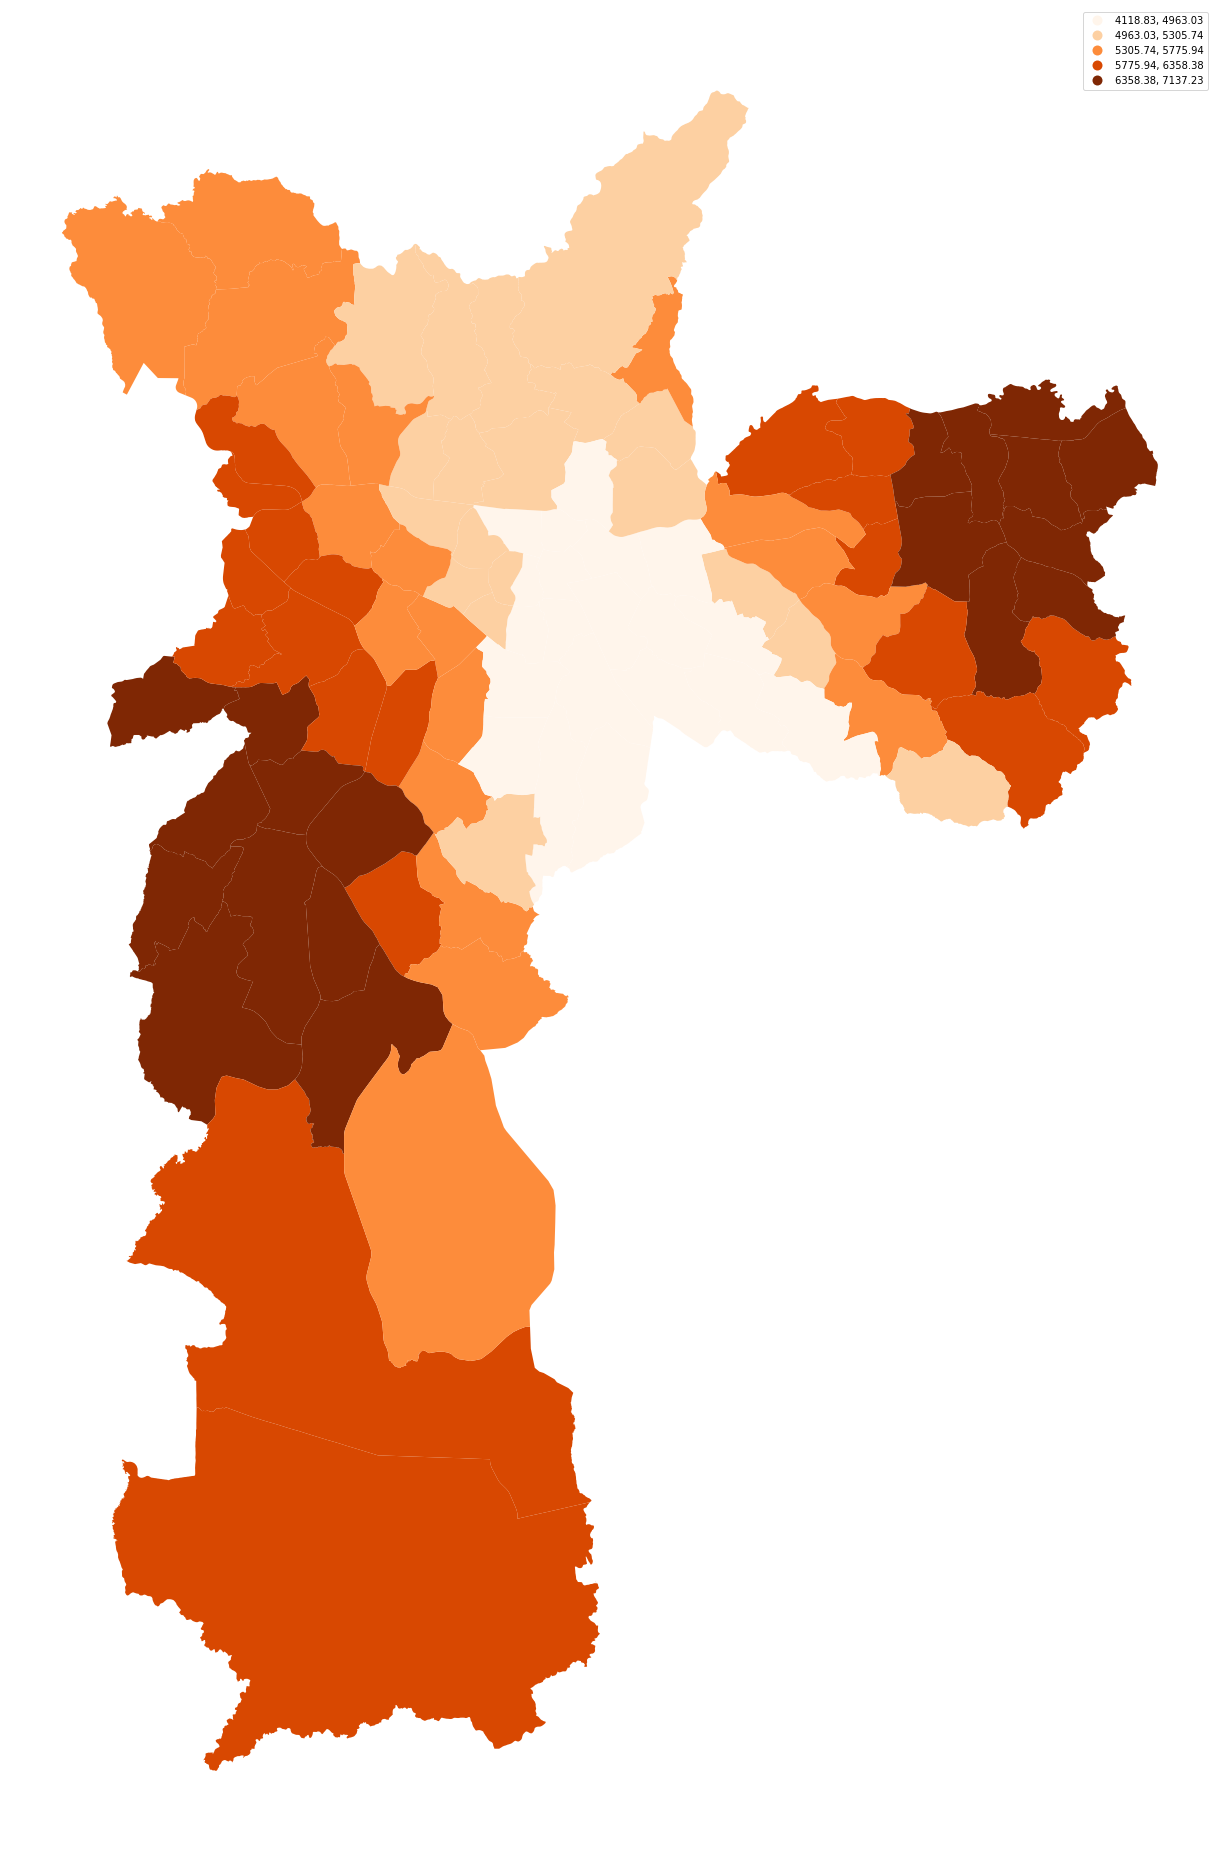

In [46]:
fig, ax = plt.subplots(figsize=(40,34))

# Set bg colors
ax.set(facecolor = "white")
fig.patch.set_facecolor('white')

# Plot
sp_shp.plot(column='distancia_desvio_padrao', scheme="Quantiles", k= 5, cmap="Oranges", legend=True, ax=ax)

ax.axis("off")
plt.show()

In [21]:
sp_shp.centroid.apply(lambda x: gdf_agencias_sp_points_join.distance(x).min())

0     2497.481121
1      984.001823
2      443.331322
3      153.236753
4      505.758166
         ...     
91     627.344200
92     149.275299
93     539.640498
94     158.482741
95      49.121678
Length: 96, dtype: float64

In [24]:
 mapclassify.Quantiles(sp_shp['menor_distancia'], k=5)

C:\Users\Ricardo\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Quantiles                   

      Interval         Count
----------------------------
[   28.56,   246.03] |    20
(  246.03,   356.51] |    19
(  356.51,   605.21] |    19
(  605.21,  1198.58] |    19
( 1198.58, 12052.77] |    19

In [28]:
 mapclassify.NaturalBreaks(sp_shp['menor_distancia'], k=5)

C:\Users\Ricardo\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Ricardo\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Ricardo\Anaconda3\lib\site-packages\sklearn\metrics

NaturalBreaks               

      Interval         Count
----------------------------
[   28.56,   731.72] |    63
(  731.72,  1712.74] |    23
( 1712.74,  3318.88] |     6
( 3318.88,  5099.06] |     3
( 5099.06, 12052.77] |     1